[![image](https://raw.githubusercontent.com/visual-layer/visuallayer/main/imgs/vl_horizontal_logo.png)](https://www.visual-layer.com)

# Analyzing Hugging Face Datasets

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/visual-layer/fastdup/blob/main/examples/analyzing-hf-datasets.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/visual-layer/fastdup/blob/main/examples/analyzing-hf-datasets.ipynb)

This notebook shows how you can use fastdup to analyze any datasets from [Hugging Face Datasets](https://huggingface.co/docs/datasets/index).

We will analyze an image classification dataset for:

+ Duplicates / near-duplicates.
+ Outliers.
+ Wrong labels.

## Installation

In [ ]:
!pip install -Uq fastdup datasets

Now, test the installation. If there's no error message, we are ready to go.

In [16]:
import fastdup
fastdup.__version__

'1.33'

## Load Dataset

In this example we load the Tiny ImageNet dataset from [Hugging Face Datasets](https://huggingface.co/datasets)..

Tiny ImageNet contains 100,000 images of 200 classes (500 for each class) downsized to 64×64 colored images. Each class has 500 training images, 50 validation images, and 50 test images.

Let's load the dataset into our local directory.

In [17]:
import datasets
dataset = datasets.load_dataset("zh-plus/tiny-imagenet", split="train", cache_dir='images_dir')

We can inspect the `dataset` object.

In [18]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 100000
})

In [19]:
dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7F01B3C34AF0>,
 'label': 0}

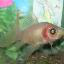

In [20]:
dataset[0]['image']

In [21]:
dataset[0]['label']

0

## Get labels mapping

Tiny ImageNet follows the original ImageNet class names. Let's download the class mappings `classes.py`.

In [22]:
!wget -q https://huggingface.co/datasets/zh-plus/tiny-imagenet/raw/main/classes.py

Here's the top 10 lines of `classes.py`.

In [23]:
!head -n 10 classes.py

i2d = {
  "n00001740": "entity",
  "n00001930": "physical entity",
  "n00002137": "abstraction, abstract entity",
  "n00002452": "thing",
  "n00002684": "object, physical object",
  "n00003553": "whole, unit",
  "n00003993": "congener",
  "n00004258": "living thing, animate thing",
  "n00004475": "organism, being",


Now we can get the class names by providing the class id. For example

In [24]:
from classes import i2d

In [25]:
i2d["n00001740"]

'entity'

## Save Images to Disk

The images are downloaded in a parquet format. Let's save them into the local disk.

In [36]:
import os
import re
from tqdm.auto import tqdm

for idx, item in tqdm(enumerate(dataset), total=len(dataset)):        
    # extract the image and label
    image = item['image']
    label = i2d[dataset.features['label'].int2str(item['label'])]

    # remove apostrophes
    label = label.replace("'", "")

    # replace commas with underscores
    label = label.replace(", ", "_")

    # replace spaces with dashes
    label = label.replace(" ", "-")

    # create a directory for the class if it doesn't exist
    label_dir = os.path.join('images_dir/images', str(label))
    os.makedirs(label_dir, exist_ok=True)

    # save the image to the appropriate directory
    image.save(os.path.join(label_dir, f'{idx}.jpg'))

  0%|          | 0/100000 [00:00<?, ?it/s]

## Load Annotations

To load the image labels into fastdup we need to prepare a DataFrame with the following column
+ `filename`
+ `label`
+ `split`


In [37]:
import os
import pandas as pd

path = 'images_dir/images'

filenames = []
labels = []

for label in os.listdir(path):
    label_path = os.path.join(path, label)
    if os.path.isdir(label_path):
        for filename in os.listdir(label_path):
            filenames.append(os.path.join(label_path, filename))
            labels.append(label)

df = pd.DataFrame({
    'filename': filenames,
    'label': labels
})

df["split"] = "train"

df



,filename,label,split
0,images_dir/images/swimming-trunks_bathing-trunks/73748.jpg,swimming-trunks_bathing-trunks,train
1,images_dir/images/swimming-trunks_bathing-trunks/73509.jpg,swimming-trunks_bathing-trunks,train
2,images_dir/images/swimming-trunks_bathing-trunks/73946.jpg,swimming-trunks_bathing-trunks,train
3,images_dir/images/swimming-trunks_bathing-trunks/73669.jpg,swimming-trunks_bathing-trunks,train
4,images_dir/images/swimming-trunks_bathing-trunks/73733.jpg,swimming-trunks_bathing-trunks,train
...,...,...,...
99995,images_dir/images/Yorkshire-terrier/11304.jpg,Yorkshire-terrier,train
99996,images_dir/images/Yorkshire-terrier/11244.jpg,Yorkshire-terrier,train
99997,images_dir/images/Yorkshire-terrier/11439.jpg,Yorkshire-terrier,train
99998,images_dir/images/Yorkshire-terrier/11290.jpg,Yorkshire-terrier,train


## Run fastdup

In [38]:
fd = fastdup.create(input_dir='images_dir/')
fd.run(annotations=df, overwrite=True)

FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.
2023-08-07 20:18:12 [INFO] Going to loop over dir /tmp/tmphta0o4og.csv
2023-08-07 20:18:12 [INFO] Found total 100000 images to run on, 100000 train, 0 test, name list 100000, counter 100000 
2023-08-07 20:21:51 [INFO] Found total 100000 images to run onmated: 0 Minutes
Finished histogram 24.316
Finished bucket sort 24.500
2023-08-07 20:22:11 [INFO] 20350) Finished write_index() NN model
2023-08-07 20:22:11 [INFO] Stored nn model index file work_dir/nnf.index
2023-08-07 20:22:22 [INFO] Total time took 249230 ms
2023-08-07 20:22:22 [INFO] Found a total of 40 fully identical images (d>0.990), which are 0.02 %
2023-08-07 20:22:22 [INFO] Found a total of 0 nearly identical images(d>0.980), which are 0.00 %
2023-08-07 20:22:22 [INFO] Found a total of 10829 above threshold images (d>0.900), which are 5.41 %
2023-08-07 20:22:22 [INFO] Found a total of 10001 outlier images         (d<0.050), which are 5.00 %
2023-08-07 2

0

## Inspect Issues

There are several methods we can use to inspect the issues found

```python
fd.vis.duplicates_gallery()    # create a visual gallery of duplicates
fd.vis.outliers_gallery()      # create a visual gallery of anomalies
fd.vis.component_gallery()     # create a visualization of connected components
fd.vis.stats_gallery()         # create a visualization of images statistics (e.g. blur)
fd.vis.similarity_gallery()    # create a gallery of similar images
```

/home/dnth/anaconda3/envs/datapull/lib/python3.10/site-packages/fastdup/galleries.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[out_col] = df[in_col].apply(lambda x: get_label_func.get(x, MISSING_LABEL))
/home/dnth/anaconda3/envs/datapull/lib/python3.10/site-packages/fastdup/galleries.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[out_col] = df[in_col].apply(lambda x: get_label_func.get(x, MISSING_LABEL))
100%|█████████████████████████████████████████████████████████████████████████████

Stored similarity visual view in  work_dir/galleries/duplicates.html
########################################################################################
Would you like to see awesome visualizations for some of the most popular academic datasets?
Click here to see and learn more: https://app.visual-layer.com/vl-datasets?utm_source=fastdup
########################################################################################



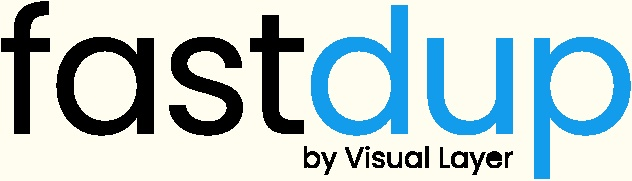
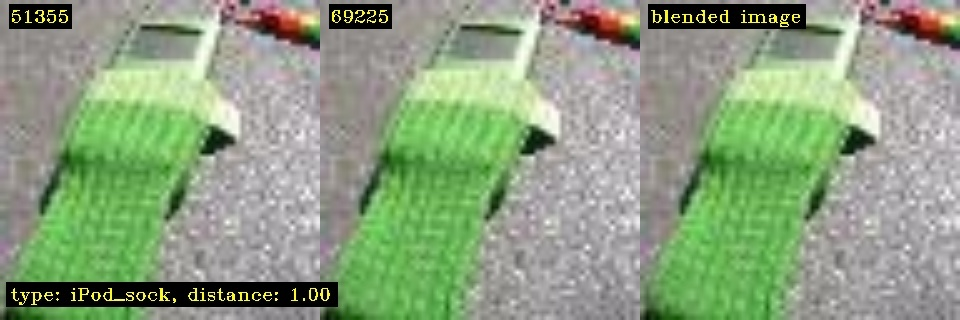
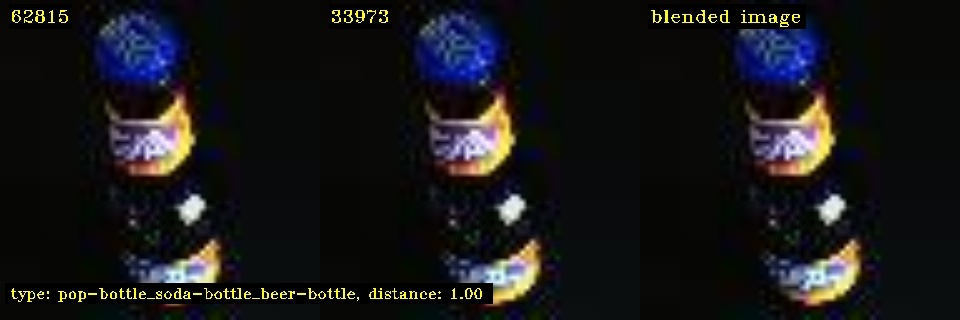
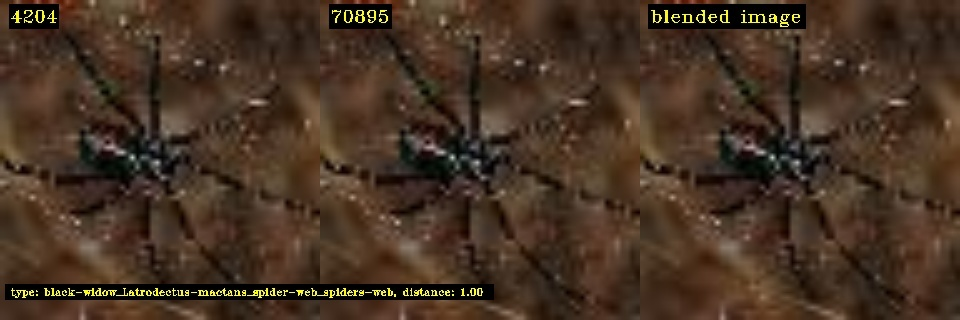
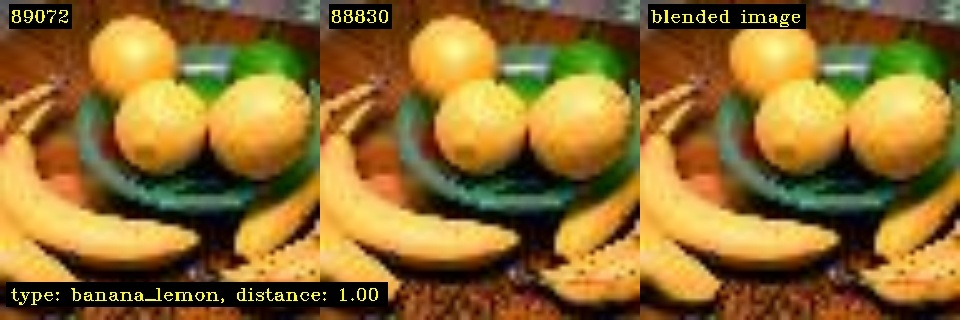
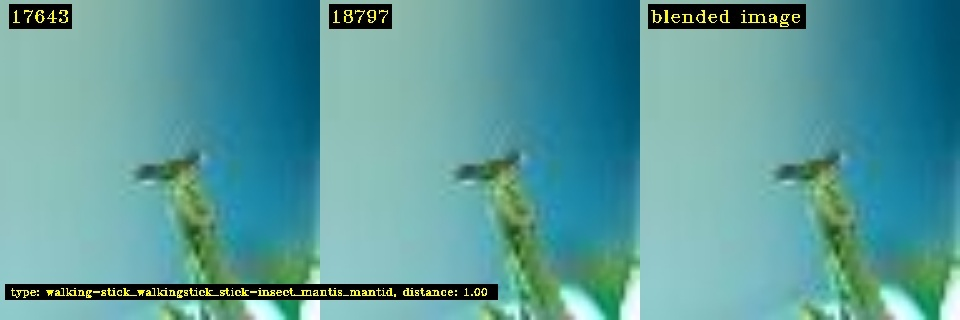
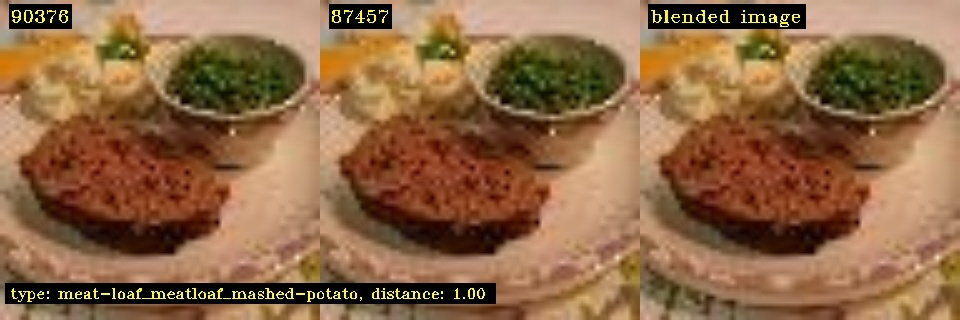
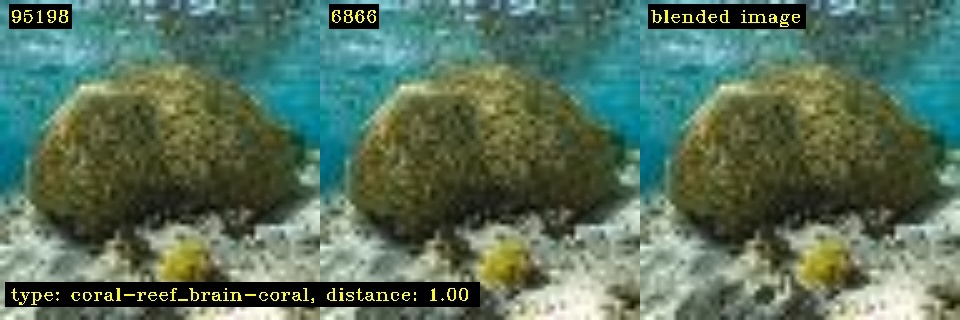
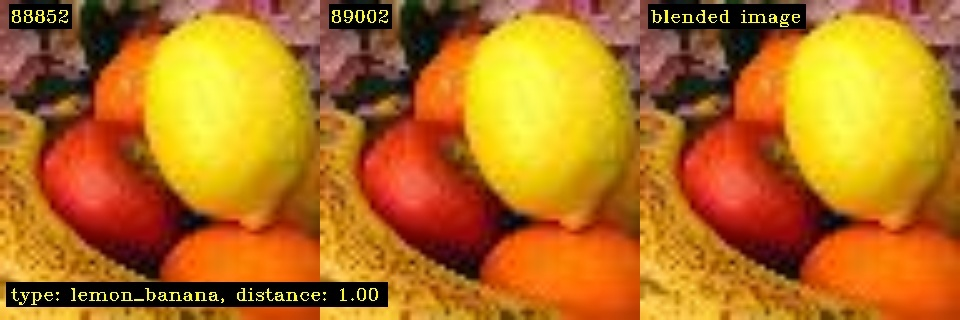
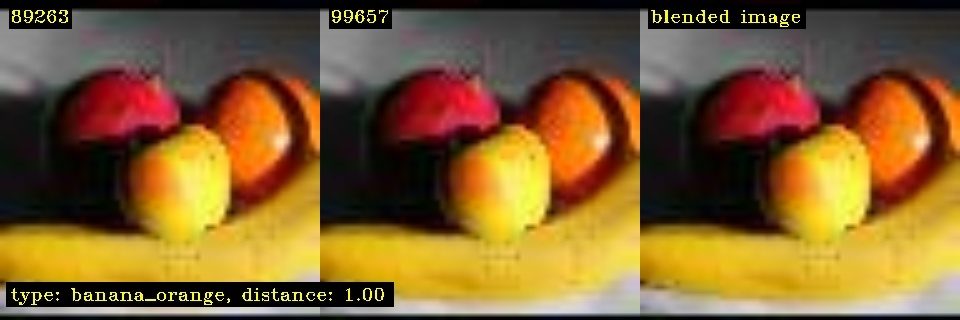
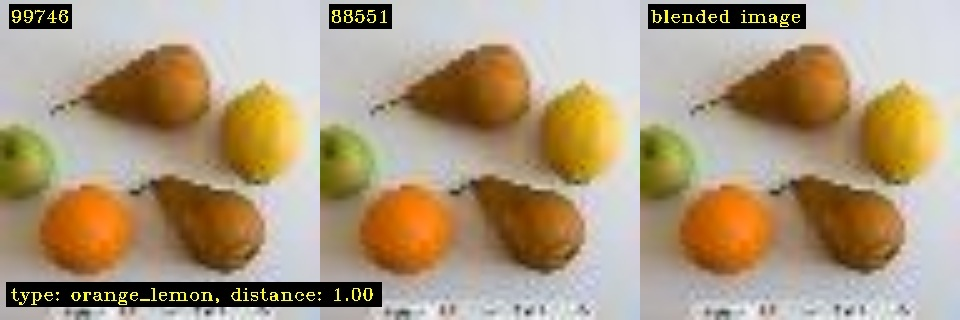
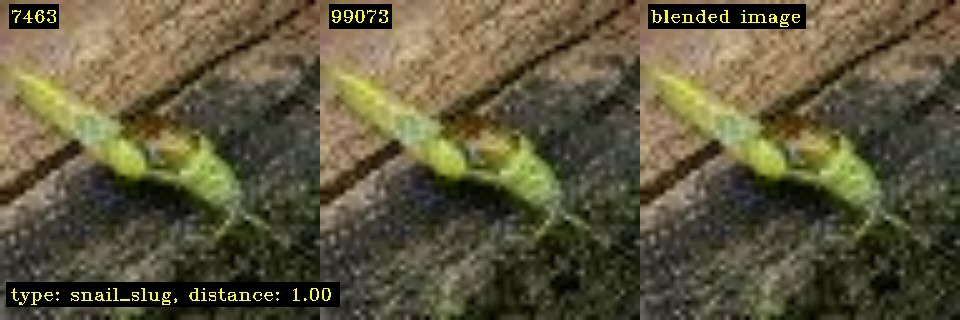
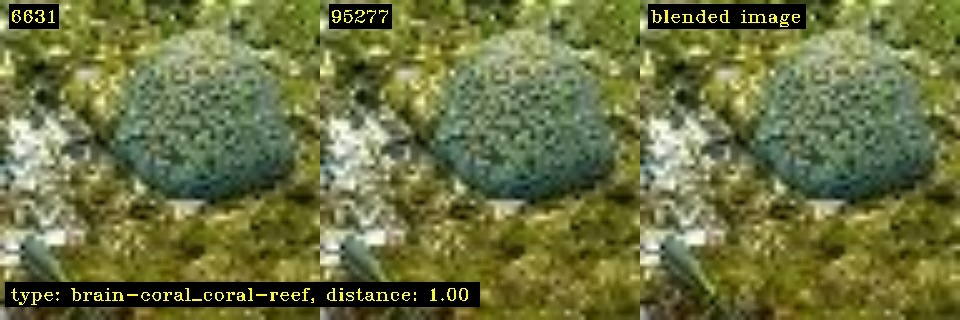

0

In [39]:
fd.vis.duplicates_gallery()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 29006.25it/s]


Stored outliers visual view in  work_dir/galleries/outliers.html
########################################################################################
Would you like to see awesome visualizations for some of the most popular academic datasets?
Click here to see and learn more: https://app.visual-layer.com/vl-datasets?utm_source=fastdup
########################################################################################



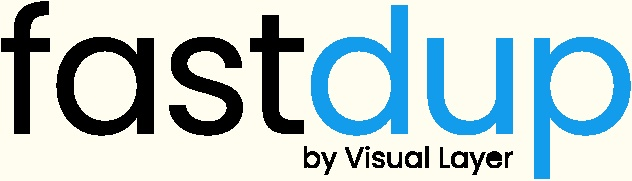
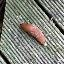
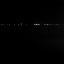
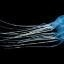
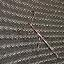
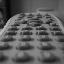
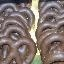
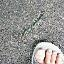
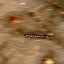
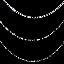
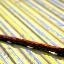
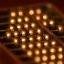
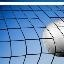
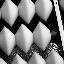
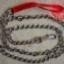
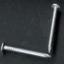
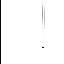
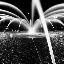
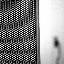
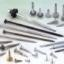
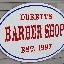

0

In [40]:
fd.vis.outliers_gallery()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 457.24it/s]


Stored similar images visual view in  work_dir/galleries/similarity.html
########################################################################################
Would you like to see awesome visualizations for some of the most popular academic datasets?
Click here to see and learn more: https://app.visual-layer.com/vl-datasets?utm_source=fastdup
########################################################################################



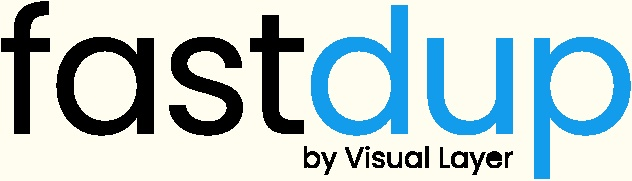
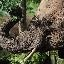
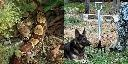
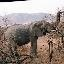
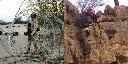
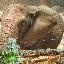
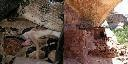
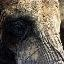
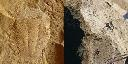
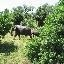
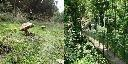
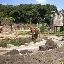
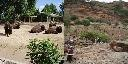
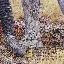
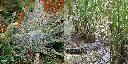
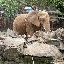
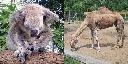
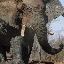
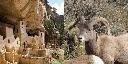
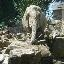
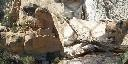
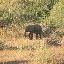
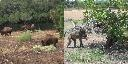
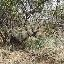
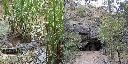
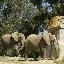
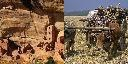
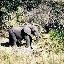
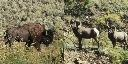
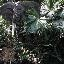
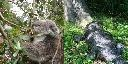
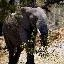
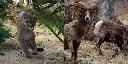
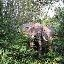
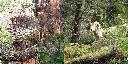
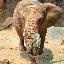
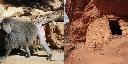
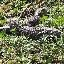
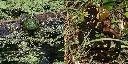
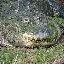
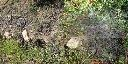

,from,to,label,label2,distance,score,length
1,images_dir/images/African-elephant_Loxodonta-africana/26003.jpg,"[images_dir/images/German-shepherd_German-shepherd-dog_German-police-dog_alsatian/12798.jpg, images_dir/images/boa-constrictor_Constrictor-constrictor/2954.jpg]","[African-elephant_Loxodonta-africana, African-elephant_Loxodonta-africana]","[German-shepherd_German-shepherd-dog_German-police-dog_alsatian, boa-constrictor_Constrictor-constrictor]","[0.900586, 0.905542]",0.0,2
5,images_dir/images/African-elephant_Loxodonta-africana/26046.jpg,"[images_dir/images/cliff_drop_drop-off/94750.jpg, images_dir/images/military-uniform/55737.jpg]","[African-elephant_Loxodonta-africana, African-elephant_Loxodonta-africana]","[cliff_drop_drop-off, military-uniform]","[0.906594, 0.90894]",0.0,2
6,images_dir/images/African-elephant_Loxodonta-africana/26049.jpg,"[images_dir/images/cliff-dwelling/41561.jpg, images_dir/images/boa-constrictor_Constrictor-constrictor/2593.jpg]","[African-elephant_Loxodonta-africana, African-elephant_Loxodonta-africana]","[cliff-dwelling, boa-constrictor_Constrictor-constrictor]","[0.905895, 0.906849]",0.0,2
7,images_dir/images/African-elephant_Loxodonta-africana/26083.jpg,"[images_dir/images/cliff_drop_drop-off/94863.jpg, images_dir/images/trilobite/3492.jpg]","[African-elephant_Loxodonta-africana, African-elephant_Loxodonta-africana]","[cliff_drop_drop-off, trilobite]","[0.904064, 0.911342]",0.0,2
13,images_dir/images/African-elephant_Loxodonta-africana/26114.jpg,"[images_dir/images/suspension-bridge/73142.jpg, images_dir/images/mushroom/97992.jpg]","[African-elephant_Loxodonta-africana, African-elephant_Loxodonta-africana]","[suspension-bridge, mushroom]","[0.92827, 0.929913]",0.0,2
...,...,...,...,...,...,...,...
7097,images_dir/images/water-tower/81086.jpg,"[images_dir/images/water-tower/81095.jpg, images_dir/images/water-tower/81128.jpg]","[water-tower, water-tower]","[water-tower, water-tower]","[0.90285, 0.905127]",100.0,2
7099,images_dir/images/water-tower/81102.jpg,"[images_dir/images/water-tower/81331.jpg, images_dir/images/water-tower/81308.jpg]","[water-tower, water-tower]","[water-tower, water-tower]","[0.903888, 0.91205]",100.0,2
7100,images_dir/images/water-tower/81128.jpg,"[images_dir/images/water-tower/81208.jpg, images_dir/images/water-tower/81086.jpg]","[water-tower, water-tower]","[water-tower, water-tower]","[0.900657, 0.905127]",100.0,2
7106,images_dir/images/water-tower/81308.jpg,"[images_dir/images/water-tower/81082.jpg, images_dir/images/water-tower/81102.jpg]","[water-tower, water-tower]","[water-tower, water-tower]","[0.904132, 0.91205]",100.0,2


In [42]:
fd.vis.similarity_gallery(slice='diff')

## Wrap Up

That's a wrap! In this notebook we showed how you can run fastdup on a Hugging Face Dataset. You can use similar methods to run on other similar datasets on [Huggging Face Datasets](https://huggingface.co/datasets).

Try it out and let us know what issues you find.


Next, feel free to check out other tutorials -

+ ⚡ [**Quickstart**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/quick-dataset-analysis.ipynb): Learn how to install fastdup, load a dataset and analyze it for potential issues such as duplicates/near-duplicates, broken images, outliers, dark/bright/blurry images, and view visually similar image clusters. If you're new, start here!
+ 🧹 [**Clean Image Folder**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/cleaning-image-dataset.ipynb): Learn how to analyze and clean a folder of images from potential issues and export a list of problematic files for further action. If you have an unorganized folder of images, this is a good place to start.
+ 🖼 [**Analyze Image Classification Dataset**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/analyzing-image-classification-dataset.ipynb): Learn how to load a labeled image classification dataset and analyze for potential issues. If you have labeled ImageNet-style folder structure, have a go!
+ 🎁 [**Analyze Object Detection Dataset**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/analyzing-object-detection-dataset.ipynb): Learn how to load bounding box annotations for object detection and analyze for potential issues. If you have a COCO-style labeled object detection dataset, give this example a try. 


# VL Profiler
If you prefer a no-code platform to inspect and visualize your dataset, [**try our free cloud product VL Profiler**](https://app.visual-layer.com) - VL Profiler is our first no-code commercial product that lets you visualize and inspect your dataset in your browser. 

[Sign up](https://app.visual-layer.com) now, it's free.

[![image](https://raw.githubusercontent.com/visual-layer/fastdup/main/gallery/vl_profiler_promo.svg)](https://app.visual-layer.com)

As usual, feedback is welcome! 

Questions? Drop by our [Slack channel](https://visualdatabase.slack.com/join/shared_invite/zt-19jaydbjn-lNDEDkgvSI1QwbTXSY6dlA#/shared-invite/email) or open an issue on [GitHub](https://github.com/visual-layer/fastdup/issues).